<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction
Transfer learning is levering a working model's existing architecure and learned patterns for our own problem.

There are two main benefits:

Can leverage an existing neural network architectuer proven to work on problem similar to our own.
Can leverage a working neural network which has alreaady learned patterns on similar data to our own, then we can adapt those patterns to our own data


In [1]:
# Are we using a GPU ?.

!nvidia-smi

Tue Feb 18 06:00:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:

!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-hub


## Downloading and becoming one with the data

In [ ]:

# Get our data (10% of 10 food classes from Food101)

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2025-02-16 18:43:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   115MB/s    in 1.4s    

2025-02-16 18:43:28 (115 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:

# How many images in each folder ?.
import os

# Walk through 10 percent data directory and list number of files.
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)
We'll use the ImageDataGenerator class to load in our images in batches

In [ ]:

# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'


# Normalizing or rescalling our images data.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from direcory and turn them into batches.
print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical'
                                                          )

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')


Training images
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (Things to run while our model trains)
Callbacks are extra functionalities you can adda to your models to be performed during or after training. Some of the most popular callbacks.

Tracking experiments with the TensorBoard callback.
Model checkpoint with the ModelCheckpoint callback.
Stopping a moel from training (before it trains too long and overfit)

In [ ]:

# Create TensorBoard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub
TensorFlow Hub is a repository of trained machine learning models.

In the past we were using TensorFlow to create our own models layer by layer from scratch.

Now we'ere to do a similar process, except majority of our models layers are going to come from TensorFlow Hub.

After a tougrough research we'll use this model in this link: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true

In [ ]:
# Let's compare the following two models.
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1';


In [ ]:

# Import dependencies.
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
# Let's create_mode() function to create a model from url
def create_model(model_url, num_classes=10):
  """
    Takes a tensorflow hub URL and creates Keras Sequential model with it.
    Args:
      model_url(str): tensorflow hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layers, should be equal to number of target classes.
  """

  # Define the input layer
  inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE + (3,))

  # Download the pretrained model and save it as a Keras layer.
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name='feature_extraction_layer',
                                            # input_shape=IMAGE_SHAPE+(3,)  # No need to specify input_shape here as it's handled by the Input layer
                                            )

  # Call the feature extraction layer with the inputs to get the output
  # Wrap the feature extraction layer call in a Lambda layer to delay execution
  x = tf.keras.layers.Lambda(lambda inputs: feature_extraction_layer(inputs))(inputs)

  # Create the output layer
  outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

  # Create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Using Functional API

  return model

## Creating and ResNet TensorFlow Hub Feature Extraction model


In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url, 10)
resnet_model


<Functional name=functional_1, built=True>

In [ ]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,490 (80.04 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile our resnet model.

resnet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
)

In [ ]:
# Fit the model.

resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                             experiment_name = 'resnet50V2')]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250215-055146


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


### Creating a feature extraction for efficientnet

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import gc

# Clear session and garbage collection
tf.keras.backend.clear_session()
gc.collect()

0

In [ ]:
# Create EfficientNet model with explicit input shape
efficientnet_model = create_model(efficientnet_url, num_classes=10)
efficientnet_model.build(input_shape=(None,) + IMAGE_SHAPE + (3,)) #Explicit shape definition

In [ ]:
efficientnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile our resnet model.

efficientnet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
)

In [ ]:
# Build the model.
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                             experiment_name = 'efficient_net')]
)

Saving TensorBoard log files to: tensorflow_hub/efficient_net/20250215-021254


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 628s 290s/step - loss: 2.3805 - val_loss: 2.3084
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - loss: 2.0428 

## Different types of Transfer learning.

 * **"As is" transfer learning** - using an exisiting model with no changes what so ever(e.g Using ImageNet model on 1000 ImageNet classes, none of your own)
 * **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem(e.g 1000 classes -> 10 classes of food)
 * **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and fine-tune many or all of the underlying layers, including new output layers

# Transfer learning with Tensorflow Part 2: Fine-tuning.

In the previous video we cover transfer learning feature extraction, now it's time to learn about a new kind of transfer learning fine-tuning

In [3]:
# check wether we're using GPU.
!nvidia-smi

Tue Feb 18 06:01:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
## Creating helper functions.

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-18 06:01:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-18 06:01:13 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import helper functions we're going to use.
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Getting data ready.

This time we're going to see how to use the pretrained models within the tf.keras.applications and apply them to our own problem.

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# Get the dataset ready.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2025-02-18 06:01:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   121MB/s    in 1.3s    

2025-02-18 06:01:19 (121 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
# walk through directories

walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [8]:
# creating training and test_dir paths.

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [9]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Found 2500 files belonging to 10 classes.
Using 500 files for validation.


In [10]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# check out class names of our dataset.
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):   # Unravel a batch
  print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

## Model 0: Building a transfer learning model using the Keras Functional API.

The sequential API is straight-forward, it runs our layers in sequenctial order but the functional API gives us more functionality with our model.

In [13]:
# 1. Create the base model wth tf.keras.appications.

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,   # Since we are dealing with feature extraction.
)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated during training)
base_model.trainable = False

 # 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer"),

 # 4. If using a model like ResNet50V2 you will need to normalize inputs(You don't have to do for efficientNet it has Rescalling build in).
#  x = tf.keras.layers.experimental.preprocessing.Rescalling(1./255)(inputs)

 #. Pass the inputs to the base_model.
x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

 # 6. Average pool the output of the base model (aggreate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avarage_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

 # 7. Create the output activation layer.
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model.
model_0 = tf.keras.Model(inputs, outputs)


# Compile the model_0
model_0.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )


# Fit the model.
model_0_history = model_0.fit(
      train_data_10_percent,
      epochs = 5,
      steps_per_epoch = len(train_data_10_percent),
      validation_data = test_data,
      validation_steps = len(test_data),
      callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                             experiment_name = 'efficient_net')]
  )

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorflow_hub/efficient_net/20250218-060133
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ('input_layer',)
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 224, 224, 3))',)
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2820 - loss: 2.1250 - val_accuracy: 0.6840 - val_loss: 1.4204
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.7163 - loss: 1.2975 - val_accuracy: 0.8100 - val_loss: 0.9710
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8096 - loss: 0.8939 - val_accuracy: 0.8480 - val_loss: 0.7595
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8476 - loss: 0.6871 - val_accuracy: 0.8580 - val_loss: 0.6519
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8671 - loss: 0.5801 - val_accuracy: 0.8780 - val_loss: 0.5855


In [14]:
# Evaluate on the full test dataset.
model_0.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8733 - loss: 0.5911


[0.5854544639587402, 0.878000020980835]

In [15]:
# Check the layers in our base model.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
# Getting the summary of the base_model.
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

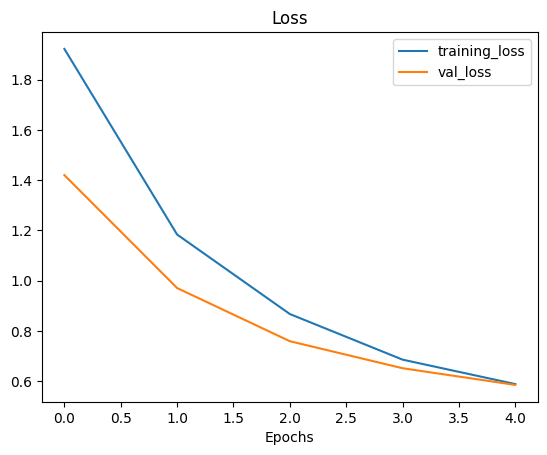

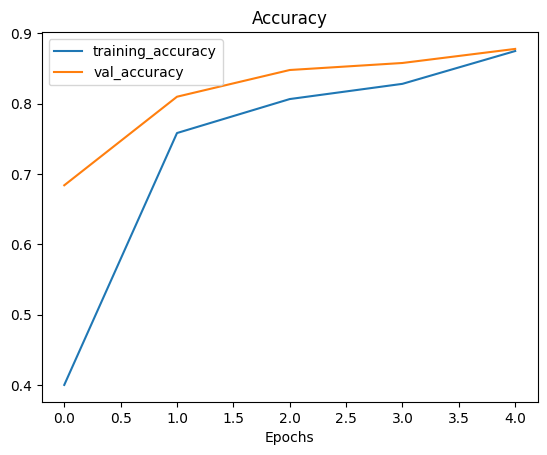

In [17]:
# Plot loss cureves.
plot_loss_curves(model_0_history)

## Get a feature vector from a train model

Let's demonstrate the Global Average Pooling 2D layer..

We have a tensor after our model goes through 'base_model' of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [18]:
# Define the input shape.
input_shape = (1,4,4,3)
# Create random tensor.
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")


# Pass the random tensor through the global average pooling 2D layer.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of output tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of output tensor: (1, 3)


In [19]:
!nvidia-smi

Tue Feb 18 06:03:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             34W /   70W |    1142MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
# Let's replicate the GlobalAveragePooling2D layer.

tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of Tranfer learning experiments.


We've seen the incredible results we've got with transfer learning. How does it go with 1% of the data ?.
Doing a series of model experiments.

1. 'model_1' - use feature extraction transfer learning with 1% of the training data. with data augmentation.

2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation.

3. 'model_3' fine-tuning transfer learning on 10% of the training data with data augmentation.
4. 'model_4' - use fine-tuning transfer learning on 100% with dat augmentation
Note: Throughout all experminets the same test dataset will be use to evaluate our model--- this ensures consistency

## Getting and preprocessing data for model_1

In [32]:
# Download and unzip data.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2025-02-18 06:11:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   209MB/s    in 0.6s    

2025-02-18 06:11:50 (209 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [33]:
 # Create training and test dirs.
 train_dir_1_percent = "10_food_classes_1_percent/train"
 test_dir = "10_food_classes_1_percent/test"

In [34]:
# How many images are we working with.
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [35]:
 # Setting up data loaders.
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# adding data augmentation to our model.

To add data augmentation right into our model, we can use the ayers inside:

* 'tf.keras.layers.experimental.preprocessing()'

In [66]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
# Create data augmenation stage.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)       # Only for ResNet50V2. the rescale is already build in for EfficientNet.
], name="data_augmentation")

In [37]:
data_augmentation

<Sequential name=data_augmentation, built=False>

## Visualize our data augmentation layer (and see what happends to our data)

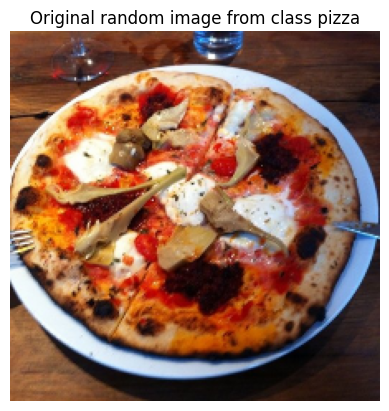

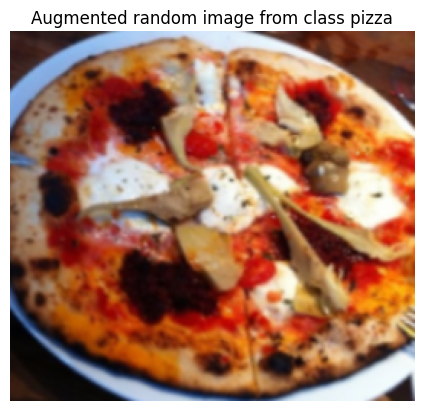

In [56]:
# View a random image and compare it to to its augmented version.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = os.path.join(target_dir, random.choice(os.listdir(target_dir)))
# print(random_image)

img = mpimg.imread(random_image)
img = tf.image.resize(img, IMG_SIZE)

img = img /255.0
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now lets read and plot the augmented image.
augmented_image = data_augmentation(img)
plt.figure()
plt.imshow(augmented_image)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False);

In [59]:
# Compiling our model_1
data_augmentation

<Sequential name=data_augmentation, built=True>

## Model 1: Feature extraction transfer learning on 1% of the data with Data Augmentation

In [67]:
# Setup input shape and base model, freezing the base model layers.

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False,    # Since we want our own layers.
)

base_model.trainable = False

# Create the input layer.
inputs = layers.Input(
    shape = input_shape,
    name="input_layer"
)

# Adding data augmentation as a layer.
x = data_augmentation(inputs)  # The inputs of our image goes to the data_augmentation layer

# Give base_model the inputs(after augmentation) and don't train.
x = base_model(x, training=False)

# Pool output features of the base model.
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output.
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)   # We we have 10 classes to predict.

# Create the model.
model_1 = tf.keras.Model(inputs, outputs)

In [68]:
# compile the model.
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                             experiment_name = '10_percent_feature_extraction_model')]
)

Saving TensorBoard log files to: tensorflow_hub/10_percent_feature_extraction_model/20250218-065328
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.0410 - loss: 2.4706 - val_accuracy: 0.1344 - val_loss: 2.2807
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.1898 - loss: 2.1446 - val_accuracy: 0.2320 - val_loss: 2.1506
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.3472 - loss: 1.9649 - val_accuracy: 0.3268 - val_loss: 2.0395
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.4890 - loss: 1.8006 - val_accuracy: 0.4088 - val_loss: 1.9379
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5806 - loss: 1.6826 - val_accuracy: 0.4740 - val_loss: 1.8399
